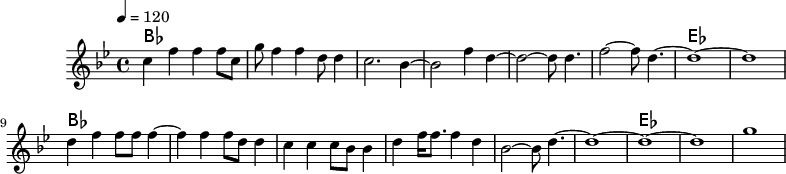

In [8]:
from sheetsage.utils import engrave
from IPython.display import display, Image

lead_sheet = sheetsage(
    retrieve_asset('TEST_FISHIN'),
    input_feats=InputFeats.HANDCRAFTED,
    output_modality=OutputModality.LEAD_SHEET,
    segment_start_hint=11,
    segment_end_hint=11 + 23.75,
    measures_per_segment=17)

lead_sheet_png = engrave(lead_sheet.as_lily())
display(Image(lead_sheet_png))

In [10]:
print(lead_sheet.as_lily())

#(set-default-paper-size "letter")

<<

\new ChordNames {
    \set majorSevenSymbol = \markup { maj7 } 
    \set additionalPitchPrefix = #"add"
    \chordmode {
        bes16*96 ees16*32 bes16*96 ees16*48
    }
}

\new Staff { 
    {
        \clef treble
        \key bes \major
        \time 4/4
        \tempo 4 = 120
        c''4 f''4 f''4 f''8 c''8 | g''8 f''4 f''4 d''8 d''4 | c''2. bes'4~ | bes'2 f''4 d''4~ | d''2~ d''8 d''4. | f''2~ f''8 d''4.~ | d''1~ | d''1 | d''4 f''4 f''8 f''8 f''4~ | f''4 f''4 f''8 d''8 d''4 | c''4 c''4 c''8 bes'8 bes'4 | d''4 f''16 f''8. f''4 d''4 | bes'2~ bes'8 d''4.~ | d''1~ | d''1~ | d''1 | g''1
    }
}

>>

\version "2.18.2"


In [9]:
print(lead_sheet)

(((0, (4, 2, 2)),), ((0, (120,)),), ((0, (10, (2, 2, 1, 2, 2, 2))),), ((0, (10, (4, 3))), (96, (3, (4, 3))), (128, (10, (4, 3))), (224, (3, (4, 3)))), ((0, 4, (0, 5)), (4, 4, (5, 5)), (8, 4, (5, 5)), (12, 2, (5, 5)), (14, 2, (0, 5)), (16, 2, (7, 5)), (18, 4, (5, 5)), (22, 4, (5, 5)), (26, 2, (2, 5)), (28, 4, (2, 5)), (32, 12, (0, 5)), (44, 12, (10, 4)), (56, 4, (5, 5)), (60, 14, (2, 5)), (74, 6, (2, 5)), (80, 10, (5, 5)), (90, 38, (2, 5)), (128, 4, (2, 5)), (132, 4, (5, 5)), (136, 2, (5, 5)), (138, 2, (5, 5)), (140, 8, (5, 5)), (148, 4, (5, 5)), (152, 2, (5, 5)), (154, 2, (2, 5)), (156, 4, (2, 5)), (160, 4, (0, 5)), (164, 4, (0, 5)), (168, 2, (0, 5)), (170, 2, (10, 4)), (172, 4, (10, 4)), (176, 4, (2, 5)), (180, 1, (5, 5)), (181, 3, (5, 5)), (184, 4, (5, 5)), (188, 4, (2, 5)), (192, 10, (10, 4)), (202, 54, (2, 5)), (256, 16, (7, 5))), 272)


In [ ]:
print(_PROBE)

In [ ]:
print(ref_tts)

In [ ]:
import pathlib
import pickle

from sheetsage import CACHE_DIR

with open(pathlib.Path(CACHE_DIR, 'test/end2end/fishin_11_handcrafted', 'audio.pkl'), 'rb') as f:
    sr, audio = pickle.load(f)

In [ ]:
from scipy.io.wavfile import write as wavwrite

wavwrite('/tmp/ugh.wav', sr, audio)

In [ ]:
import numpy as np

with open(pathlib.Path(CACHE_DIR, 'test/end2end/fishin_11_handcrafted', 'beattrack.pkl'), 'rb') as f:
    beats_per_bar, offset, duration, tertiary_times = pickle.load(f)

ref_tts = np.array(tertiary_times)
print(ref_tts[0])

In [ ]:
extractor = _init_extractor(InputFeats.HANDCRAFTED)
offset = ref_tts[0]
fr, feats = extractor('/tmp/ugh.wav', offset=offset, duration=ref_tts[-1] - offset)
beat_resampled = []
chunk_tertiaries = ref_tts
for i in range(chunk_tertiaries.shape[0] - 1):
    s = int((chunk_tertiaries[i] - offset) * fr)
    e = int((chunk_tertiaries[i + 1] - offset) * fr)
    assert e > s
    beat_resampled.append(np.mean(feats[s:e], axis=0, keepdims=True))
beat_resampled = np.concatenate(beat_resampled, axis=0)
print(beat_resampled.shape)

In [5]:
import pathlib
import pickle
from sheetsage import CACHE_DIR

with open(pathlib.Path(CACHE_DIR, 'test/end2end/fishin_11_handcrafted', 'feats.pkl'), 'rb') as f:
    ref_feats = pickle.load(f)
#my_feats = beat_resampled
my_feats = _PROBE

for i in range(my_feats.shape[0]):
    print(np.abs(ref_feats[i] - my_feats[i]).mean())

1.5593362
0.2268187
0.2215797
0.25272584
0.26576138
0.18659577
0.17798458
0.15954657
0.2877036
0.2124149
0.15645343
0.24528903
0.19929485
0.23745613
0.40461072
0.21284094
0.29867
0.20238441
0.2554714
0.29789555
0.19377151
0.32710758
1.7687328
2.4491522
0.15537032
0.20675465
0.24078691
0.18934727
1.548763
1.2810475
0.28055182
0.2607475
0.31307468
0.30314097
0.19822603
0.13649945
0.19459507
0.34728342
0.22349125
0.15760206
0.3032555
0.26039076
0.35315642
0.15992214
0.33226597
0.20264044
0.16656782
0.22238342
0.31106144
0.29454428
0.18970813
0.26956537
0.3534772
0.16262011
1.5177964
1.0288134
0.18272129
0.28595397
0.2077756
0.20964068
0.35699266
0.18511228
0.22930026
0.13955821
0.26972696
0.34052587
0.16055082
0.15767057
1.7473544
1.2586174
0.18913226
0.2144446
0.16849741
0.14773576
2.379571
1.0966227
0.19790016
0.18567215
0.13300069
0.1375953
0.3836121
0.1789704
0.1468915
0.14916739
0.38303486
0.16903916
0.29428056
0.20308796
0.14207944
0.16037914
0.32628557
0.18852946
0.3065625
0.172434

In [ ]:
my = _PROBE
#print(ref[:my.shape[0]])
#print(my)
for i in range(my.shape[0]):
    if ref[i] != my[i]:
        print(i, ref[i], my[i])

In [ ]:
from sheetsage.utils import decode_audio

sr, audio = decode_audio(retrieve_asset('TEST_FISHIN'))
print(sr, audio.shape, audio.dtype, audio.min(), audio.max())

In [ ]:
from sheetsage.utils import decode_audio, retrieve_audio_bytes

audio_bytes = retrieve_audio_bytes('https://www.youtube.com/watch?v=fHI8X4OXluQ')
print(len(audio_bytes))